## This notebook: BRCA Dataset
This is the demo notebook for benchmarking on BRCA Dataset (10x Genomics).

### Data Loading
The input data contains both Visium and Xenium data from the 10x Genomics website, and a transformation matrix to map Visium coordinates to Xenium (See manuscript for more details).
Here, we load a prepared dump file.

In [1]:
import pickle
vi, xe, R = pickle.load(open("BRCA.dmp", "rb"))
vi.var_names_make_unique()
xe.var_names_make_unique()
if hasattr(vi.X, "toarray"): vi.X = vi.X.toarray()
if hasattr(xe.X, "toarray"): xe.X = xe.X.toarray()

### Gene Imputation
- We use every 10th gene in the Xenium panel as the holdout gene.
- We use codes provided in ``lib_eval`` to compute average R^2 score over the holdouts.
- We also use ``scanpy.pl.spatial`` to show spatial distribution of an imputed gene.

In [2]:
import sys
import os.path
code_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "src"))
sys.path.append(code_dir)
import lib_helper

holdouts = list(xe.var_names)[::10]
ret = lib_helper.impute_genes(vi, xe, holdouts, 20, R, lr = 1e-2, epochs = 5000)

/n/fs/ragr-data/users/hz7140/xenium-int-v2/siid/src/nmf_v01.py:48: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  sparse_csr_tensor = torch.sparse_csr_tensor(crow_indices, col_indices, values, size=array.shape)


Training the model with poisson loss
Epoch 0, Loss: 135011856.0, Xenium (KL/Fro) divergence: 127602256.0, Visium (KL/Fro) divergence: 7409601.0, Regularization 6.354728698730469, Entropy -2.9957265853881836
Epoch 500, Loss: -3545962.5, Xenium (KL/Fro) divergence: 213531.34375, Visium (KL/Fro) divergence: -3759748.0, Regularization 254.1712188720703, Entropy -2.1563847064971924
Epoch 1000, Loss: -5935275.0, Xenium (KL/Fro) divergence: -1967105.5, Visium (KL/Fro) divergence: -3968502.0, Regularization 332.46826171875, Entropy -3.7784440517425537
Epoch 1500, Loss: -6224809.5, Xenium (KL/Fro) divergence: -2225911.5, Visium (KL/Fro) divergence: -3999288.25, Regularization 390.7365417480469, Entropy -6.520628929138184
Epoch 2000, Loss: -6373575.5, Xenium (KL/Fro) divergence: -2362652.5, Visium (KL/Fro) divergence: -4011366.25, Regularization 443.60882568359375, Entropy -11.031646728515625
Epoch 2500, Loss: -6448175.0, Xenium (KL/Fro) divergence: -2430655.0, Visium (KL/Fro) divergence: -40180

In [3]:
import lib_eval
print('average holdout R^2:', lib_eval.avg_corr_by_col(ret.X, xe[:, ret.var_names].X))

average holdout R^2: 0.24810331466859115


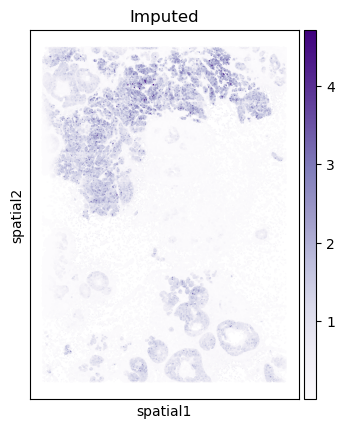

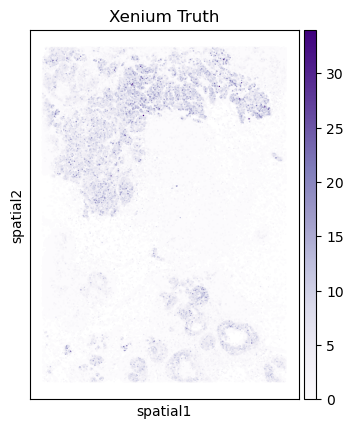

In [4]:
import scanpy as sc
ret.obsm['spatial'] = xe.obsm['spatial']
g = holdouts[0]
sc.pl.spatial(ret, color = [g], spot_size=30, title = "Imputed", color_map = "Purples")
sc.pl.spatial(xe, color = [g], spot_size=30, title = "Xenium Truth", color_map = "Purples")

### Cell Type Estimation
We run ``lib_helper.infer_latent_types`` to extract inferred latent cell types (called factors in the manuscript).
In addition, we use ``scanpy.pl.spatial`` to show spatial distribution of an imputed gene.

In [6]:
Px, Pv = lib_helper.infer_latent_types(vi, xe, 20, R, lr = 1e-2, epochs = 5000)

Training the model with poisson loss
Epoch 0, Loss: 158371008.0, Xenium (KL/Fro) divergence: 149138528.0, Visium (KL/Fro) divergence: 9232473.0, Regularization 6.3551130294799805, Entropy -2.9957265853881836
Epoch 500, Loss: -5928782.5, Xenium (KL/Fro) divergence: -2029543.5, Visium (KL/Fro) divergence: -3899487.5, Regularization 248.2533721923828, Entropy -4.780262470245361
Epoch 1000, Loss: -8802483.0, Xenium (KL/Fro) divergence: -4848201.5, Visium (KL/Fro) divergence: -3954616.0, Regularization 335.2669982910156, Entropy -17.929018020629883
Epoch 1500, Loss: -9031150.0, Xenium (KL/Fro) divergence: -5060184.0, Visium (KL/Fro) divergence: -3971406.25, Regularization 440.09112548828125, Entropy -65.26341247558594
Epoch 2000, Loss: -9120686.0, Xenium (KL/Fro) divergence: -5141976.0, Visium (KL/Fro) divergence: -3979363.75, Regularization 653.5211181640625, Entropy -228.14871215820312
Epoch 2500, Loss: -9164264.0, Xenium (KL/Fro) divergence: -5181984.0, Visium (KL/Fro) divergence: -39835

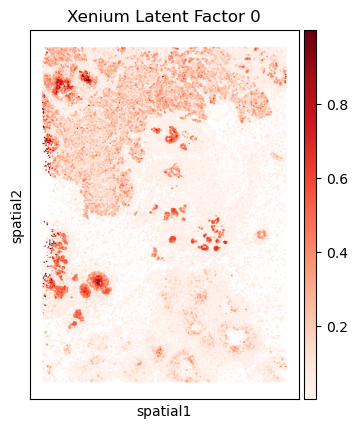

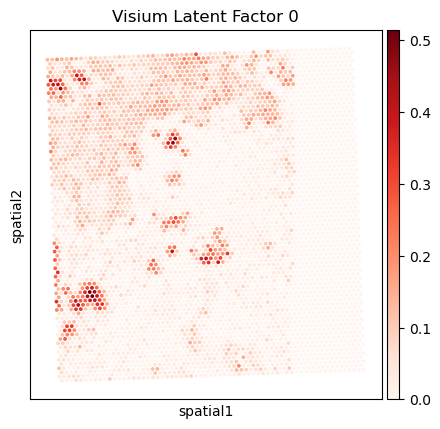

In [8]:
for i in range(20):
    Px.obs[i] = Px.X[:, i]
    Pv.obs[i] = Pv.X[:, i]
sc.pl.spatial(Px, color = [0], spot_size=30, title = "Xenium Latent Factor 0", color_map = "Reds")
sc.pl.spatial(Pv, color = [0], spot_size=80, title = "Visium Latent Factor 0", color_map = "Reds")